In [1]:
import cv2 as cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import time

In [2]:
print(cv2.__version__)

4.1.2


In [3]:
cat_img_path = os.path.join(os.getcwd(),'images','cat_1700.jpg')
print(cat_img_path)

C:\Users\paulmi\Desktop\MachineLearning\ConvImgProcessing\images\cat_1700.jpg


(333, 324, 3)


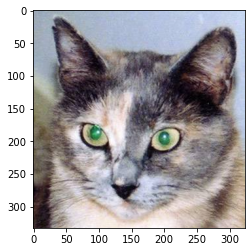

In [4]:
img = cv2.imread(cat_img_path)
print(img.shape)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img = img[:,0:323,:]
plt.imshow(img)

In [5]:
def zero_pad(X, pad):
    """
    Pad with zeros the given X image. The padding is applied to the height and width of an image
    
    Argument:
    X -- python numpy array of shape (n_H, n_W, n_C) representing image
    pad -- integer, amount of padding around each image on vertical and horizontal dimensions
    
    Returns:
    X_pad -- padded image of shape (n_H + 2*pad, n_W + 2*pad, n_C)
    """
#     print(X.shape)
    X_pad = np.pad(X,((pad,pad),(pad,pad),(0,0)), mode='constant', constant_values = (0,0))
   
    
    return X_pad

In [6]:
def slice_conv(img_slice, kernel):
    """
    Apply one filter defined by parameters W on a single slice (a_slice_prev) of the input data (image)
   
    Arguments:
    image_slice -- slice of input data (image) of shape (f, f, n_C_prev)
    kernel -- kernel contained in a window - matrix of shape (f, f, n_C_prev)
    
    Returns:
    Z -- a scalar value, the result of convolving the sliding window fxf on a slice x of the input data (image)
    """
    # Element-wise product between img_slice and W. Do not add the bias yet.
    s = np.multiply(img_slice, kernel)
    # Sum over all entries of the volume s.
    Z = np.sum(s)

    return Z

In [7]:
def channel_slice_conv(img_slice, kernel):
    """
    Apply one filter defined by parameters W on a single slice (a_slice_prev) of the input data (image)
   
    Arguments:
    image_slice -- slice of input data (image) of shape (f, f, n_C_prev)
    kernel -- kernel contained in a window - matrix of shape (f, f, n_C_prev)
    
    Returns:
    Z -- a scalar value, the result of convolving the sliding window fxf on a slice x of the input data (image)
    """
    # Element-wise product between img_slice and W. Do not add the bias yet.
    s = np.multiply(img_slice, kernel)
    Z = np.sum(s,axis=(0,1))

    return Z

In [8]:
img_slice = img[300:303,100:103,0]
print(img_slice.shape)
avg_kernel = np.full((3,3,3), fill_value=1/9)
# print(channel_slice_conv(img_slice, avg_kernel))

(3, 3)


In [9]:
def convolution2D(img,kernel,mode='channel_wise'):
    """
    Implements the convolution operation on the given image with the given kernel
    
    Arguments:
    img -- input image, numpy array of shape (n_H_prev, n_W_prev, n_C_prev)
    kernel -- numpy array of shape (f, f, n_C_prev)
    mode -- one of 'channel_wise' or full. 
        channel_wise -> will perfom the convolution on channel-by-channel basis 
                        which will return a list of 3 floating point numbers, i.e.
                        one for each color channel
        full -> will perfom the convolution over the entire slice volume
                and will will return a floating point number, i.e the result of the entire volume convolution   
        
    Returns:
    Z -- conv output, numpy array of shape (n_H, n_W, n_C)
    """
    
    # Retrieve dimensions from img's shape
    (n_H_prev, n_W_prev, n_C_prev) = img.shape
    
    # Retrieve dimensions from kernel's shape
    (f, f, n_C_prev) = kernel.shape
    
    stride = 1 # pixel by pixel convolution
    pad = int((f-1)/2) # 'same' convolution formula
    
    # Compute the dimensions of the CONV output of shape (n_H,n_W).  
    n_H = int((n_H_prev + 2*pad - f)/stride) + 1
    n_W = int((n_W_prev + 2*pad - f)/stride) + 1
    n_C = 3

    
    t0 = time.time()
    if (mode == 'channel_wise'):
        # Initialize the output volume Z with zeros. 
        Z = np.zeros((n_H,n_W,n_C))
        
        # Create img_pad by padding img    
        img_pad = zero_pad(img, pad)
        
        for h in range(n_H):           # loop over vertical axis of the output volume
            # Find the vertical start and end of the current "slice" 
            vert_start = h
            vert_end = h+f

            for w in range(n_W):       # loop over horizontal axis of the output volume
                # Find the horizontal start and end of the current "slice" 
                horiz_start = w
                horiz_end = w+f

                img_slice = img_pad[vert_start:vert_end,horiz_start:horiz_end,:]
                Z[h, w] = channel_slice_conv(img_slice[:,:], kernel)   
                
        # Making sure your output shape is correct 
        assert(Z.shape == (n_H, n_W, n_C))  
        
    elif (mode == 'full'):  
        # Initialize the output volume Z with zeros. 
        Z = np.zeros((n_H,n_W))

        # Create img_pad by padding img    
        img_pad = zero_pad(img, pad)
            
        for h in range(n_H):           # loop over vertical axis of the output volume
            # Find the vertical start and end of the current "slice" 
            vert_start = h
            vert_end = h+f

            for w in range(n_W):       # loop over horizontal axis of the output volume
                # Find the horizontal start and end of the current "slice" 
                horiz_start = w
                horiz_end = w+f

                img_slice = img_pad[vert_start:vert_end,horiz_start:horiz_end,:]
                Z[h, w] = slice_conv(img_slice, kernel)
        # Making sure your output shape is correct
        assert(Z.shape == (n_H, n_W))    

    t1 = time.time()

    total = t1-t0
    print("convolution time: ",total)

    return Z 


In [106]:
simple_box_blur_kernel = np.full((7,7,3), fill_value=1/49)
print(simple_box_blur_kernel.shape)
print(simple_box_blur_kernel)
simple_box_3_all_img = convolution2D(img,simple_box_blur_kernel,mode='full')/255
simple_box_3_cw_img = convolution2D(img,simple_box_blur_kernel,mode='channel_wise')/255

(7, 7, 3)
[[[0.02040816 0.02040816 0.02040816]
  [0.02040816 0.02040816 0.02040816]
  [0.02040816 0.02040816 0.02040816]
  [0.02040816 0.02040816 0.02040816]
  [0.02040816 0.02040816 0.02040816]
  [0.02040816 0.02040816 0.02040816]
  [0.02040816 0.02040816 0.02040816]]

 [[0.02040816 0.02040816 0.02040816]
  [0.02040816 0.02040816 0.02040816]
  [0.02040816 0.02040816 0.02040816]
  [0.02040816 0.02040816 0.02040816]
  [0.02040816 0.02040816 0.02040816]
  [0.02040816 0.02040816 0.02040816]
  [0.02040816 0.02040816 0.02040816]]

 [[0.02040816 0.02040816 0.02040816]
  [0.02040816 0.02040816 0.02040816]
  [0.02040816 0.02040816 0.02040816]
  [0.02040816 0.02040816 0.02040816]
  [0.02040816 0.02040816 0.02040816]
  [0.02040816 0.02040816 0.02040816]
  [0.02040816 0.02040816 0.02040816]]

 [[0.02040816 0.02040816 0.02040816]
  [0.02040816 0.02040816 0.02040816]
  [0.02040816 0.02040816 0.02040816]
  [0.02040816 0.02040816 0.02040816]
  [0.02040816 0.02040816 0.02040816]
  [0.02040816 0.020408

In [107]:
avg_kernel = np.full((3,3,3), fill_value=1/9)

print(img[0:3,0:3,:])
print('*'*40)
print(avg_kernel)
print('='*40)
slice_res = img[0:3,0:3,:]*avg_kernel
print(slice_res)
# print('----slice_res[0]=',slice_res[0])
Z = np.sum(slice_res,axis=0,keepdims=True)
print('along X axis'+'-'*40)
print(Z)
Z = np.sum(Z,axis=1,keepdims=True)
print('then along Y axis'+'-'*40)
print(Z)

print('axis01'+'-'*40)
Z = np.sum(slice_res,axis=(0,1),keepdims=True)
print(Z)
print(Z.shape)
print('axis12'+'-'*40)
Z = np.sum(slice_res,axis=(1,2),keepdims=True)
print(Z)
print(Z.shape)


[[[164 174 186]
  [163 173 185]
  [161 170 185]]

 [[166 176 188]
  [165 175 187]
  [163 172 187]]

 [[165 175 187]
  [164 174 186]
  [162 171 186]]]
****************************************
[[[0.11111111 0.11111111 0.11111111]
  [0.11111111 0.11111111 0.11111111]
  [0.11111111 0.11111111 0.11111111]]

 [[0.11111111 0.11111111 0.11111111]
  [0.11111111 0.11111111 0.11111111]
  [0.11111111 0.11111111 0.11111111]]

 [[0.11111111 0.11111111 0.11111111]
  [0.11111111 0.11111111 0.11111111]
  [0.11111111 0.11111111 0.11111111]]]
[[[18.22222222 19.33333333 20.66666667]
  [18.11111111 19.22222222 20.55555556]
  [17.88888889 18.88888889 20.55555556]]

 [[18.44444444 19.55555556 20.88888889]
  [18.33333333 19.44444444 20.77777778]
  [18.11111111 19.11111111 20.77777778]]

 [[18.33333333 19.44444444 20.77777778]
  [18.22222222 19.33333333 20.66666667]
  [18.         19.         20.66666667]]]
along X axis----------------------------------------
[[[55.         58.33333333 62.33333333]
  [54.66666

In [108]:
print(simple_box_3_all_img[100:103,300:303])
print('-'*40)
print(simple_box_3_cw_img[100:103,300:303,:])

[[0.97326931 1.05114046 1.14237695]
 [0.89179672 0.95646259 1.04713886]
 [0.80544218 0.85930372 0.95446178]]
----------------------------------------
[[[0.35846339 0.29843938 0.31636655]
  [0.37823129 0.3270108  0.34589836]
  [0.40192077 0.36014406 0.38031212]]

 [[0.33557423 0.2709884  0.28523409]
  [0.35142057 0.2947579  0.31028411]
  [0.37519008 0.327491   0.34445778]]

 [[0.31036415 0.24177671 0.25330132]
  [0.3232493  0.26162465 0.27442977]
  [0.34893958 0.29547819 0.31004402]]]


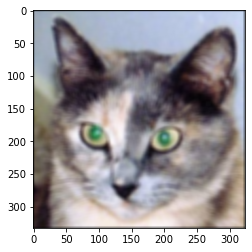

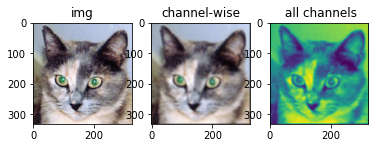

In [109]:
plt.imshow(simple_box_3_cw_img)
fig, axarr = plt.subplots(1, 3)
axarr[0].set_title('img')
axarr[0].imshow(img[:,:,:])
axarr[1].set_title('channel-wise')
axarr[1].imshow(simple_box_3_cw_img[:,:,:]),
axarr[2].set_title(' all channels')
axarr[2].imshow(simple_box_3_all_img[:,:])


In [120]:
channel_1 = np.array([[[-0.5],[-1],[-0.5]], [[-1],[7],[-1]], [[-0.5],[-1],[-0.5]]])
channel_2 = channel_1.copy()
channel_3 = channel_1.copy()
aa = np.dstack((channel_1,channel_2,channel_3))


[[[-0.5]
  [-1. ]
  [-0.5]]

 [[-1. ]
  [ 7. ]
  [-1. ]]

 [[-0.5]
  [-1. ]
  [-0.5]]]
(3, 3, 1)
[[[-0.5 -0.5 -0.5]
  [-1.  -1.  -1. ]
  [-0.5 -0.5 -0.5]]

 [[-1.  -1.  -1. ]
  [ 7.   7.   7. ]
  [-1.  -1.  -1. ]]

 [[-0.5 -0.5 -0.5]
  [-1.  -1.  -1. ]
  [-0.5 -0.5 -0.5]]]
(3, 3, 3)


In [125]:
channel_1 = np.array([[[-0.5],[-1],[-0.5]], [[-1],[7],[-1]], [[-0.5],[-1],[-0.5]]])
channel_2 = channel_1.copy()
channel_3 = channel_1.copy()
sharpen_kernel = np.dstack((channel_1,channel_2,channel_3))

print(img[0:3,0:3,:])
print('*'*40)
print(sharpen_kernel)
print('='*40)
slice_res = img[0:3,0:3,:]*sharpen_kernel
print(slice_res)
print('-'*40)
Z = np.sum(slice_res,axis=(0,1))
print(Z)


[[[164 174 186]
  [163 173 185]
  [161 170 185]]

 [[166 176 188]
  [165 175 187]
  [163 172 187]]

 [[165 175 187]
  [164 174 186]
  [162 171 186]]]
****************************************
[[[-0.5 -0.5 -0.5]
  [-1.  -1.  -1. ]
  [-0.5 -0.5 -0.5]]

 [[-1.  -1.  -1. ]
  [ 7.   7.   7. ]
  [-1.  -1.  -1. ]]

 [[-0.5 -0.5 -0.5]
  [-1.  -1.  -1. ]
  [-0.5 -0.5 -0.5]]]
[[[ -82.   -87.   -93. ]
  [-163.  -173.  -185. ]
  [ -80.5  -85.   -92.5]]

 [[-166.  -176.  -188. ]
  [1155.  1225.  1309. ]
  [-163.  -172.  -187. ]]

 [[ -82.5  -87.5  -93.5]
  [-164.  -174.  -186. ]
  [ -81.   -85.5  -93. ]]]
----------------------------------------
[173. 185. 191.]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


convolution time:  2.6070396900177


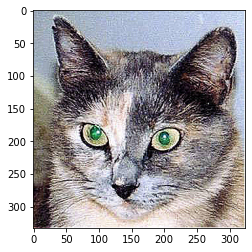

In [163]:
sharpened_img = convolution2D(img, sharpen_kernel, mode='channel_wise')
# sharpened_img[sharpened_img>255] = 255 
# sharpened_img[sharpened_img<0] = 0 

plt.imshow(sharpened_img/255)

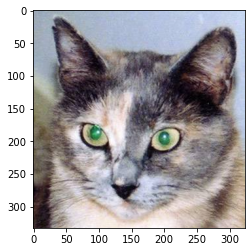

In [172]:
plt.imshow(img)

In [174]:
sharpened_img[0:5,0:5,:]


array([[[736.5, 781.5, 835.5],
        [486.5, 518. , 549.5],
        [479. , 504.5, 554. ],
        [474. , 496.5, 543. ],
        [457. , 497.5, 538. ]],

       [[504.5, 534.5, 570.5],
        [173. , 185. , 191. ],
        [168.5, 175.5, 196.5],
        [166.5, 169.5, 186.5],
        [161. , 179. , 191. ]],

       [[500. , 530. , 566. ],
        [170. , 182. , 188. ],
        [164.5, 171.5, 192.5],
        [170. , 173. , 190. ],
        [155. , 173. , 185. ]],

       [[485. , 515. , 551. ],
        [159. , 171. , 177. ],
        [153. , 160. , 181. ],
        [157.5, 160.5, 177.5],
        [141.5, 159.5, 171.5]],

       [[482. , 512. , 548. ],
        [157.5, 169.5, 175.5],
        [150.5, 157.5, 178.5],
        [153.5, 156.5, 173.5],
        [144. , 162. , 174. ]]])

In [183]:

# Get the index of elements with value 15
result = np.where(sharpened_img < 0)

h,w,c = result[0][0], result[1][0], result[2][0]
print(print(h,w,c))
print(sharpened_img[h,w,c])
h,w,c = result[0][10], result[1][10], result[2][0]
print(print(h,w,c))
print(sharpened_img[h,w,c])
# print('Tuple of arrays returned : ', result)
# print("Elements with value 15 exists at following indices", result[0], sep='\n')

13 43 0
None
-28.0
15 44 0
None
-79.5


In [104]:
a = np.array([[0,2],[0,2]])
b = np.array([[1,2],[1,2]])

In [105]:
print(np.dstack((a,b)))

[[[0 1]
  [2 2]]

 [[0 1]
  [2 2]]]


In [184]:
sharpened_img[12:15,42:45,:]

array([[[ 88.5,  93. ,  94. ],
        [  1.5,  12.5,   7. ],
        [ 24.5,  34. ,  34. ]],

       [[ 26. ,  16. ,  29.5],
        [-28. , -22.5, -22.5],
        [ 80. ,  67. ,  81. ]],

       [[ 96. ,  84.5,  94. ],
        [ 40.5,  45.5,  39.5],
        [ 77.5,  64.5,  71. ]]])

In [ ]:
sharpened_img[12:15,42:45,:]


In [185]:
sharpened_img[15:18,42:45,:]


array([[[181. , 174.5, 191. ],
        [ 59.5,  53.5,  54.5],
        [-79.5, -83.5, -67.5]],

       [[ 53.5,  52.5,  59.5],
        [214.5, 217.5, 233.5],
        [124.5, 116. , 137. ]],

       [[ 21. ,  20. ,  37. ],
        [ 85. ,  90. , 101.5],
        [ 93.5,  87.5, 109.5]]])

<h3>Sobel Filter</h3>

For the Sobel operator, like all other linear filter, one can apply the filter to each of the channels independently. That is, the output red channel is the filtered input red channel, etc.

In image processing, an edge is the points where the image brightness changes sharply, i.e. the outlines

In [81]:
# Create the vertical, left to right edge detection kernel:
# [[-1,0,1],
# [-2,0,2],
# [-1,0,1]]

vt_lt_sobel_channel_1 = np.array([[[-1],[0],[1]], [[-2],[0],[2]], [[-1],[0],[1]]])
vt_lt_sobel_channel_2 = vt_lt_sobel_channel_1.copy()
vt_lt_sobel_channel_3 = vt_lt_sobel_channel_1.copy()
vt_lt_sobel_kernel = np.dstack((vt_lt_sobel_channel_1,vt_lt_sobel_channel_2,vt_lt_sobel_channel_3))
# vt_lt_sobel_kernel=vt_lt_sobel_kernel/8
print(vt_lt_sobel_kernel)

[[[-1 -1 -1]
  [ 0  0  0]
  [ 1  1  1]]

 [[-2 -2 -2]
  [ 0  0  0]
  [ 2  2  2]]

 [[-1 -1 -1]
  [ 0  0  0]
  [ 1  1  1]]]


<h4>Channel by channel convolution</h4>

In [126]:
lt_edge_img = convolution2D(img, vt_lt_sobel_kernel, mode='channel_wise')

convolution time:  1.2505204677581787


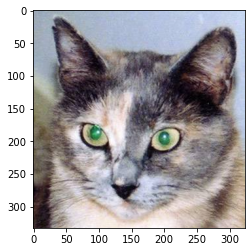

In [127]:
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


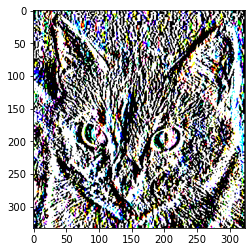

In [128]:
plt.imshow(lt_edge_img)

In [129]:
print(lt_edge_img[50:55,295:300,:])


[[[ -56.  -48.  -48.]
  [ -94.  -78.  -70.]
  [ -68.  -60.  -44.]
  [ -53.  -45.  -21.]
  [ -81.  -73.  -53.]]

 [[ -49.  -41.  -41.]
  [-114.  -98.  -90.]
  [ -79.  -71.  -55.]
  [ -48.  -40.  -16.]
  [ -69.  -61.  -41.]]

 [[ -25.  -17.  -17.]
  [ -81.  -65.  -57.]
  [ -82.  -74.  -58.]
  [ -68.  -60.  -36.]
  [ -84.  -76.  -56.]]

 [[ -18.  -10.  -10.]
  [ -31.  -15.   -7.]
  [ -64.  -56.  -40.]
  [ -97.  -89.  -65.]
  [-118. -110.  -90.]]

 [[ -37.  -29.  -29.]
  [  -4.   12.   20.]
  [ -22.  -14.    2.]
  [-110. -102.  -78.]
  [-143. -135. -115.]]]


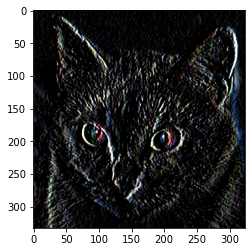

In [130]:
lt_edge_img[lt_edge_img>255] = 255 
lt_edge_img[lt_edge_img<0] = 0 

plt.imshow(lt_edge_img/255)

In [131]:
print(lt_edge_img.shape)

(333, 324, 3)


In [132]:
print(img[0:3,0:3,:])
print('*'*40)
print(vt_lt_sobel_kernel)
print('='*40)
slice_res = img[0:3,0:3,:]*vt_lt_sobel_kernel
print(slice_res)
print('-'*40)
Z = np.sum(slice_res,axis=(0,1))
print(Z)

[[[164 174 186]
  [163 173 185]
  [161 170 185]]

 [[166 176 188]
  [165 175 187]
  [163 172 187]]

 [[165 175 187]
  [164 174 186]
  [162 171 186]]]
****************************************
[[[-1 -1 -1]
  [ 0  0  0]
  [ 1  1  1]]

 [[-2 -2 -2]
  [ 0  0  0]
  [ 2  2  2]]

 [[-1 -1 -1]
  [ 0  0  0]
  [ 1  1  1]]]
[[[-164 -174 -186]
  [   0    0    0]
  [ 161  170  185]]

 [[-332 -352 -376]
  [   0    0    0]
  [ 326  344  374]]

 [[-165 -175 -187]
  [   0    0    0]
  [ 162  171  186]]]
----------------------------------------
[-12 -16  -4]


In [133]:
print(lt_edge_img[50:55,295:300,:])


[[[ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]]

 [[ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]]

 [[ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]]

 [[ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]]

 [[ 0.  0.  0.]
  [ 0. 12. 20.]
  [ 0.  0.  2.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]]]


<h4>Full convolution</h4>

In [134]:
lt_edge_img_full = convolution2D(img, vt_lt_sobel_kernel, mode='full')

convolution time:  0.9275195598602295


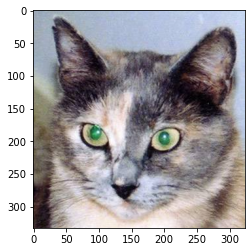

In [135]:
plt.imshow(img)

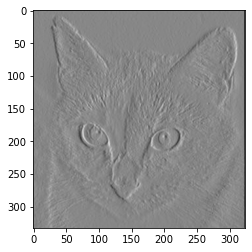

In [136]:
plt.imshow(lt_edge_img_full,cmap='gray')

In [137]:
print(lt_edge_img_full[50:55,295:300])


[[-152. -242. -172. -119. -207.]
 [-131. -302. -205. -104. -171.]
 [ -59. -203. -214. -164. -216.]
 [ -38.  -53. -160. -251. -318.]
 [ -95.   28.  -34. -290. -393.]]


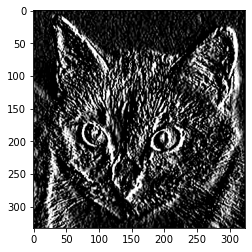

In [125]:
lt_edge_img_full[lt_edge_img_full>255] = 255 
lt_edge_img_full[lt_edge_img_full<0] = 0 

plt.imshow(lt_edge_img_full,cmap='gray')

In [114]:
print(lt_edge_img_full[50:60,295:320])


[[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  91. 255. 255. 255.
  255. 255. 255. 182.   0.  52.  26.   0.   0.  27.  48.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   9.   0.  10. 255. 255. 255.
  255. 255. 255. 255.  50.  70.   8.   0.   0.   1.  56.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 220. 255. 255.
  255. 255. 255. 255. 116.  70.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.  65.   0. 142. 255. 255.
  255. 255. 255. 255. 164.  52.   0.   0.  29.   0.   0.]
 [  0.  28.   0.   0.   0.   0.   0.   0.   0. 164.   0.  55. 255. 255.
  255. 255. 255. 255. 185.  31.   0.   0.  65.  15.   0.]
 [  0.  16. 152.   0.   0.   0.   0.   0.   0.  80.  55.  70. 255. 255.
  255. 255. 255. 255. 179.  37.   0.   0.  62.  37.   0.]
 [  0.   0. 255. 121.   0.   0.   0.   0.   0.   0.  70. 148. 255. 255.
  255. 255. 255. 255. 146.  58.   0.   0.  29.  60.   6.]
 [  0.  40. 255. 238.   0.   0.   0.   0.   0.   0.   0. 145. 255. 252.
  255. 255. 255. 2